# Machine Learning for metabolomes of microbial communities

In [1]:
# imports
import sys
sys.path.append( '../FIA' )
sys.path.append( '../ML' )
sys.path.append( '..' )

from helpers import *
from FIA import *
from ML4com import *

## Loading in

In [2]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")
metData = pd.read_csv("../../data/comm8_0/metData.tsv", sep="\t")
metData.index = pd.read_csv("../../data/comm8_0/metName.tsv", sep="\t")

met_raw_pos = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos")
met_raw_neg = pd.read_excel("../../data/comm8_0/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg")

In [3]:
def join_df_metNames(df):
    cols = ["metNames"] + [f"MS{i+1}" for i in range(len(df.columns) - 6)]
    comb = pd.DataFrame(columns=cols)
    for pid in df["peakID"].unique():
        comb_met_name = ""
        for met_name in df.loc[df["peakID"] == pid]["MetName"]:
            comb_met_name += met_name + "\n"
        comb.loc[len(comb.index)] = [comb_met_name[:-2]] + list(df.loc[df["peakID"] == pid].iloc[0, 6:])
    comb = comb.set_index('metNames')
    return comb

## Normalization

In [4]:
met_raw_comb = pd.concat( [total_ion_count_normalization( join_df_metNames(met_raw_pos) ), total_ion_count_normalization( join_df_metNames(met_raw_neg) )] )

In [5]:
X = met_raw_comb.transpose()
ys = comm8
targets = strains.values.flatten()

## Learning and tuning

In [6]:
run_dir = "../../runs/ML/annot"

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
    {"random_state": [42],
     "ccp_alpha": [0.01]}
]

results = train_cv_model(DecisionTreeClassifier, param_grid, X, ys, targets, os.path.join(run_dir, "decision_tree"), suffix="", n_fold=5)

Parameter combinations 1:


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
    {"random_state": [42],
     "ccp_alpha": [0.01]}
]

grids = grid_search_params_cv_model(DecisionTreeClassifier, param_grid, X, ys.values, targets, n_splits=5, n_jobs=1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
[CV] END ....................ccp_alpha=0.01, random_state=42; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....

## Random Forest

### Standard

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {"random_state": [42],
     "ccp_alpha": [0, 0.5, 0.025],
     "n_estimators": [10, 100, 400],
     "max_depth": [None, 5, 20]}
]

results = train_cv_model(RandomForestClassifier, param_grid, X, ys, targets, os.path.join(run_dir, "random_forest"), suffix="", n_fold=5)

Parameter combinations 1:


100%|██████████| 27/27 [03:07<00:00,  6.96s/it]


### BaggingClassifier

In [12]:
from sklearn.ensemble import BaggingClassifier
param_grid = [
    {"random_state": [42],
     "bootstrap": [True],
     "bootstrap_features": [True],
     "oob_score": [True, False],
     "n_estimators": [10, 100, 400],
     "n_jobs": [4]}
]

results = train_cv_model(BaggingClassifier, param_grid, X, ys, targets, os.path.join(run_dir, "bagging"), suffix="", n_fold=5)
res_df = pd.concat([results, pd.json_normalize(results["parameters"])], axis=1)
res_df.to_csv(os.path.join(run_dir, "gradient_boost.tsv"), sep="\t")

Parameter combinations 1:


  0%|          | 0/6 [00:00<?, ?it/s]


ValueError: Out of bag estimation only available if bootstrap=True

### Gradient Boosting

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = [
    {"random_state": [42],
     "ccp_alpha": [0, 0.5, 0.025],
     "loss": ["exponential", "log_loss"],
     "learning_rate": [0.1, 0.2 , 0.5],
     "n_estimators": [10, 100, 200],
     "max_depth": [None, 1, 2, 3, 5],
     "n_iter_no_change": [20]}
]

results = train_cv_model(GradientBoostingClassifier, param_grid, X, ys, targets, os.path.join(run_dir, "gradient_boost"), suffix="", n_fold=5)
res_df = pd.concat([results, pd.json_normalize(results["parameters"])], axis=1)
res_df.to_csv(os.path.join(run_dir, "gradient_boost_2.tsv"), sep="\t")

Parameter combinations 1:


100%|██████████| 108/108 [47:46<00:00, 26.54s/it] 


##### Extreme Gradiant Boosting

In [13]:
from xgboost import XGBClassifier

param_grid = [
    {"seed": [42],
     "objective": ['binary:logistic'],  
     "min_split_loss": [0, 1, 5],                       # = gamma
     "min_child_weight": [1, 5],                        # larger -> more conservative (gives up exploration if weight is under..)
     "max_delta_step": [0],                              # larger -> more conservative, for imbalanced datasets
     "lambda": [1],                                     # L2 regularization -""-
     "alpha": [0],                                     # L1 regularization -""-
     "num_parallel_tree": [1, 4],                       # Allows boosted RF
     "subsample": [0.5, 1.0],
     "learning_rate": [0.01, 0.1],
     "n_estimators": [10, 100, 200],
     "max_depth": [None, 5, 20]}
]

results = train_cv_model(XGBClassifier, param_grid, X, ys, targets, os.path.join(run_dir, "gradient_boost"), suffix="", n_fold=5)
res_df = pd.concat([results, pd.json_normalize(results["parameters"])], axis=1)
res_df.to_csv(os.path.join(run_dir, "gradient_boost.tsv"), sep="\t")


Parameter combinations 1:


  0%|          | 0/1296 [00:00<?, ?it/s]c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "ccp_alpha", "n_iter_no_change" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "ccp_alpha", "n_iter_no_change" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "cc

KeyboardInterrupt: 

### SVM

In [ ]:
from sklearn.svm import SVC
param_grid = [
    {"random_state": [42],
     "kernel": ["linear"],
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]},

     {"random_state": [42],
     "kernel": ["poly"],
     "degree": [2, 3],
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]},

    {"random_state": [42],
     "kernel": ["sigmoid"],             # tanh
     "coef0" : np.logspace(-2, 3, 6),
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]},

    {"random_state": [42],
     "kernel": ["rbf",],
     "gamma": np.logspace(-4, 2, 7),
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]}
]

results = train_cv_model(SVC, param_grid, X, ys, targets, os.path.join(run_dir, "svm"), suffix="", n_fold=5)

Parameter combinations 1:


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Parameter combinations 2:


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Parameter combinations 3:


100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Parameter combinations 4:


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


### Multi-Layer-Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
param_grid = [
    {"random_state": [42],
     "activation": ["identity", "relu"],
     "solver": ['adam'],
     "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1],
     "hidden_layer_sizes": [(500, 100), (100, 100), (20, 100), (100, 20), (500, 20)],
     "max_iter": [1000]}
]

results = train_cv_model(MLPClassifier, param_grid, X, ys, targets, os.path.join(run_dir, "multi_layer_perceptron"), suffix="", n_fold=5)

Parameter combinations 1:


  0%|          | 0/60 [00:00<?, ?it/s]

c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
  2%|▏         | 1/60 [05:19<5:13:59, 319.32s/it]

## Analysis

In [ ]:
plot_df = pd.concat([results, pd.json_normalize(results["parameters"])], axis=1)
plot_df

,model_nr,parameters,target,accuracy,random_state,ccp_alpha
0,1,"{'random_state': 42, 'ccp_alpha': 0.01}",C. ramosum,0.985294,42,0.01
1,1,"{'random_state': 42, 'ccp_alpha': 0.01}",R. gnavus,0.955882,42,0.01
2,1,"{'random_state': 42, 'ccp_alpha': 0.01}",C. aerofaciens,0.970588,42,0.01
3,1,"{'random_state': 42, 'ccp_alpha': 0.01}",B. thetaiotaomicron,0.985294,42,0.01
4,1,"{'random_state': 42, 'ccp_alpha': 0.01}",B. uniformis,0.573529,42,0.01
5,1,"{'random_state': 42, 'ccp_alpha': 0.01}",B. vulgatus,0.955882,42,0.01
6,1,"{'random_state': 42, 'ccp_alpha': 0.01}",F. nucleatum,0.838235,42,0.01
7,1,"{'random_state': 42, 'ccp_alpha': 0.01}",R. intestinalis,0.985294,42,0.01


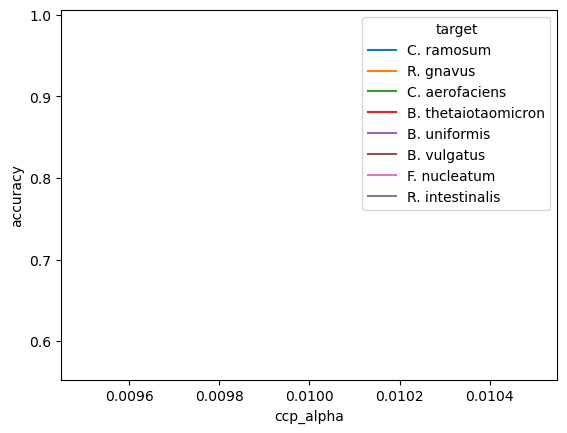

In [ ]:
ax = sns.lineplot(data=plot_df, y="accuracy", x="ccp_alpha", hue="target")

## In-depth analysis

In [ ]:
model = DecisionTreeClassifier(random_state=42)

# for i, estimator in enumerate(model.estimators_):
for i, s in enumerate(strains):
    model.fit(X.transpose(),ys.transpose()[i])
    plot_decision_trees(model=model, feature_names=X.index, class_names=["absent", s], outdir=outdir, name=f"decisiontree/tree_{s}{suffix}")